The stochastic simulation algorithm (SSA), or Gillespie algorithm, provides a means to sample directly from the state
distribution of a system governed by the master equation. Whilst this methodology has been used for the simulation of chemical
reactions for decades, its applicability and utility in the simulation of dynamical processes on networks is not well known.
We will look at an implementation the Gillespie Algorithm for an epidemic process on an random network, and consider the implementation issues when using Numpy.

The Model
---

We will look at one of the most simplistic models simple model of epidemic spread, the SI model. An *node* (person) can either be susceptible (S) or infected (I) with a disease. Nodes are connected along *links* which describe some interaction between the two bodies for which the disease may possibly travel. For example, our network might contain links between every two people who have passed within 5 metres of each other over a day [1]. Simpler networks could be family ties, coworkers, and coinhabitants if such high resolution data isn't achievable. 

The model consists of two reactions,
$$\begin{align} 
    S + I &\xrightarrow{\lambda} I + I,  \\
    S &\xrightarrow{\gamma} I.
    \end{align}$$
    
A susceptible node can meet an infected node and subsequently become infected itself with some probability (contagion). A susceptible node can also spontaneously become infected by itself (spontaneous infection). This accounts for any chance of becoming infected which is not accounted for in our model otherwise.
    

In [14]:
from simulation import SI_Simulation # Import the model.

In [45]:
G = nx.erdos_renyi_graph(1000,0.05) # Use Networkx to generate a random graph.

In [46]:
model = SI_Simulation(G, lam=0.8, gam=0.001, i0=0.0) # Setup the simulation with given parameters.
model.RunToConvergence() # Run the simulation.
model.IntegrateSolution() # Numerically integrate the mean field equations.

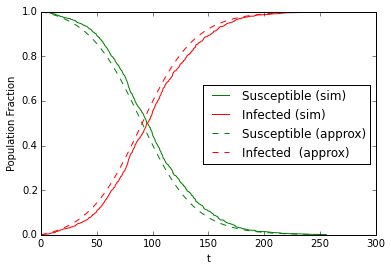

In [50]:
# Simulation.
plot(model.times,model.S/model.N, 'g-', label='Susceptible (sim)');
plot(model.times,model.I/model.N, 'r-', label='Infected (sim)');

# Numerical Integration.
t = np.linspace(0,model.times[-1],100)
plot(t, model.solution[:,0],'g--', label='Susceptible (approx)');
plot(t, model.solution[:,1],'r--', label='Infected  (approx)');

xlabel('t')
ylabel('Population Fraction')

legend(bbox_to_anchor=(1.0,0.7));

The simulation approximately follows the mean-field prediction[2] which assumes all nodes have the same degree and are identical in their placement in the network. The number of infected follows an S-shaped curve; infection is slow at first and then rapidily increases before slowing towards the final state.

This model and the S-shaped curve has been used in marketing to model the adoption of consumer products from as early as 1969. The [Bass Model](http://en.wikipedia.org/wiki/Bass_diffusion_model) as it is called is one of the top 5 most frequently cited papers in the 50-year history of the journal *Management Science*. One might rightly question why such a simple model has been so well adopted when it is such an oversimplification. Partly the reason is due to the ability to fit parameters to data, or most likely *over-fit* parameters to data, but that is a different issue entirely!

The literature on epidemic and innovation models is extremely rich and is at a point where any written review of it would be outdated by the time it was finished. For now we'll look at how to simulate these models on a network.

Gillespie
---
The [Gillespie algorithm](http://en.wikipedia.org/wiki/Gillespie_algorithm), or the stochastic simulation algorithm
(SSA) was first introduced in 1976 as a means of
providing statistically exact simulations of reacting chemical
species within a reaction volume. There are also
a number of improvements and approximations which have
been suggested, the most famous of which are the Gibson-Bruck algorithm[3] and the  Tau-leap approximation[4].

Traditional simulation methods are *interval*-driven; they
choose a small time step $\Delta t$ and consider whether a reaction
happens in the interval $[t, t + \Delta t)$. These types of simulations
come in two different flavours, synchronous updating
where each node has a chance to react during an interval and
asynchronous updating, where a individual node is chosen at
random and then given the possibility to react. Interestingly
enough, these two simulation schemes can give different results
depending on the dynamics at play. One also has
to take into consideration the length of time step which can
have considerable effects on the reliability of the results however
it is possible to choose these values sensibly to reduce
error. Another caveat of interval
methods is that they can be extremely computationally inefficient. There may be multiple intervals computed before
a reaction takes place, especially if the rate of reaction is
small. This means that multiple random numbers are generated
which have no effect on the system. In practice, the
time interval is chosen such that the expected number of reactions
in an interval is one however this requires the interval
length to be adjusted as the simulation evolves and reaction
propensities change.

By contrast the Gillespie algorithm is *event*-driven; it calculates
the time until the next event happens then progresses
time forward until that time and executes the event. This
means that an *infintesimally small* time increment $dt$ is never
approximated by a finite timestep $\Delta t$. It also has the added
advantage that each iteration of the algorithm responds to
a reaction or event meaning that computation is not wasted as in the traditional counterparts.

The implementation follows the simple steps

>    1.  Generate two random numbers $r_1$, $r_2$ picked from a uniform distribution on $(0,1)$.
>    2.  + Compute the propensity function $\alpha_i^m(t)$ for each node $i$ and reaction $m$.
>        + Compute the total propensity for the system,
>    $$\begin{align}
    \alpha_0 = \sum_{m=1}^{M}\sum_{i=1}^{N}\alpha_i^m(t). 
    \end{align}$$ 
>    3. Compute the time until the next reaction takes place as 
>    $$\begin{align}
    \tau = \frac{1}{\alpha_0}\log\left( \frac{1}{r_1} \right). 
    \end{align}$$
>    4. Compute which reaction occurs at time $t+\tau$, i.e. find $k,j$ such that
>    $$\begin{align}
    r_2 \geq \frac{1}{\alpha_0}\sum_{m=1}^{k-1}\sum_{i=1}^{j-1}\alpha_i^m(t) \hspace{1ex} \text{and} \hspace{1ex} r_2 < \frac{1}{\alpha_0}\sum_{m=1}^{k}\sum_{i=1}^{j}\alpha_i^m(t).
    \end{align}$$
>    5. Update the node states and propensities for the $k$-th reaction of  the $j$-th node.
>    6. Repeat from step 1(a) from time $t+\tau$.

Code
---

The model is implemented as a Python class which keeps track of the individual node states as well as the overall level of infected and susceptible nodes. The main functions are *RunIteration()* where the Gillespie algorithm is run, and *UpdatePropensity()* which calculates the propensities for nodes to become infected. You will see that there are in fact 5 seperate implementations of the *UpdatePropensity()* function. This is the computational bottleneck of the simulation and so, in the next section we explore the merits and caveats of these different implementations.

In [ ]:
import networkx as nx
import numpy as np

class SI_Simulation():
    """
    A class to simulate the SI Model.
    ===================================================
    Input: A - Network adjacency matrix (numpy array) or Networkx graph object.
           lam - Contagion parameter.
           gam - Spontaneous infection parameter.
           i0 - Initial infected fraction.
           prop - Propensity calculation method [ALL,TAKE,FANCY,LOOP,SLICE].
    """

    def __init__(self, A, lam=0.1, gam=0.001, i0=0.1, prop='ALL'):

        # Network setup.
        if type(A)==np.ndarray:
            self.A = A
        elif type(A)==nx.classes.graph.Graph:
            self.A = nx.adj_matrix(A).A
        else:
            raise BaseException("Input an adjacency matrix or networkx object only.")

        # Model Parameters.
        self.N = A.shape[0]
        self.lam = lam/self.N
        self.gam = gam
        self.prop = prop

        # Time-keeping.
        self.t = 0
        self.times = [0]
        
        # Node numbers.
        self.I = [int(i0*self.N)]
        self.S = [self.N-self.I[0]]
        
        # Node states.
        self.X = np.array([1]*self.S[0] +[2]*self.I[0]).reshape((self.N,1))
        np.random.shuffle(self.X)
         
        # Initial propensity setup.        
        self.UpdatePropensityALL() 
        
        # Select which propensity scheme to use.
        if self.prop == 'ALL':
            self.UpdatePropensity = self.UpdatePropensityALL 
        elif self.prop == 'FANCY':
            self.UpdatePropensity = self.UpdatePropensityFANCY 
        elif self.prop == 'TAKE':
            self.UpdatePropensity = self.UpdatePropensityTAKE 
        elif self.prop == 'SLICE':
            self.UpdatePropensity = self.UpdatePropensitySLICE
        elif self.prop == 'LOOP':
            self.UpdatePropensity = self.UpdatePropensityLOOP
        else:
            raise BaseException("Please specify a propensity scheme [ALL,TAKE,FANCY,LOOP,SLICE].")
        return None
        
    def UpdatePropensityALL(self, n_nodes=None):
        self.IP = (self.gam + self.lam*self.A.dot(self.X==2))*(self.X==1)
        return None
    
    def UpdatePropensityTAKE(self,n_nodes):   
        self.IP[n_nodes] = (self.gam + self.lam*np.take(self.A,n_nodes, axis=0).dot(self.X==2))*((np.take(self.X,n_nodes, axis=0)==1))
        return None    
    
    def UpdatePropensityFANCY(self,n_nodes):
        self.IP[n_nodes] = (self.gam + self.lam*self.A[n_nodes].dot(self.X==2))*(self.X[n_nodes]==1)
        return None
        
    def UpdatePropensityLOOP(self,n_nodes):        
        for node in n_nodes:
            self.IP[node] = (self.gam + self.lam*self.A[node].dot(self.X==2))*(self.X[node]==1)
        return None
    
    def UpdatePropensitySLICE(self,n_nodes):        
        nmax, nmin = n_nodes.max()+1, n_nodes.min()
        self.IP[nmin:nmax] = (self.gam + self.lam*self.A[nmin:nmax,:].dot(self.X==2))*(self.X[nmin:nmax]==1)
        return None
        
    def RunIteration(self):
        
        # Termination.
        if self.S[-1] == 0:
            self.S = np.array(self.S, dtype=float)
            self.I = np.array(self.I, dtype=float)
            return False

        # 1. Generate random numbers r1,r2 uniformly distributed in (0,1)
        r1 = np.random.rand()
        r2 = np.random.rand()
        
        # 2. Calculate alpha.
        cumsum = self.IP.cumsum()
        self.alpha = cumsum[-1]

        # 3. Compute the time until the next reaction takes place.
        tau = (1.0/self.alpha)*np.log(float(1.0/r1))
        self.t += tau
        self.times.append(self.t)

        # 4. Compute which reaction takes place.
        index = np.searchsorted(cumsum,r2*self.alpha)

        # 5. Update node states. 
        self.X[index%self.N] = 2
        self.S.append(self.S[-1] - 1)
        self.I.append(self.I[-1] + 1)
            
        # 6. Update propensities
        n1 = np.nonzero(self.A[index%self.N])[0]
        n1 = np.append(n1,index%self.N)
        
        self.UpdatePropensity(n1)
        return True

    def RunToConvergence(self):
        running = True
        while running:
            running = self.RunIteration()
        return None
    
    def IntegrateSolution(self):
        from scipy.integrate import odeint
        gam = self.gam
        lam = self.lam*self.N
        k = self.A.sum(axis=0).mean()

        def deriv(x,t):
            xdot = [-x[0]*(gam + lam*x[1]),
                    +x[0]*(gam + lam*x[1])]
            return xdot

        x0 = [float(self.S[0])/self.N,float(self.I[0])/self.N]
        t = np.linspace(0,self.times[-1],100)
        x = odeint(deriv,x0,t)
        self.solution = x
        return None

This framework is designed to be general. Provided the propensity of a reaction is properly calculated, and the network states updated then any number of reactions can be cast into this form, including dynamics which alter the structure of the network itself.

Efficiency
---

In theory, this is the currently the most efficient way of implementing the model, however intricases in the Python language (and the Numpy package) require that more thought is given as to how it is written.

The most intensive aspect of the algorithm is the calculation of the propensities for each node (and reaction).
This can be written in terms of matrix multiplication.

$$ \underline{\alpha} = (\gamma \textbf{1} + \lambda \textbf{A}\textbf{1}_{\{infected\}}) \circ \textbf{1}_{\{susceptible\}} $$

where $\circ$ is the element-wise vector multiplication and $(\textbf{1}_{\{infected\}})_i = 1$ if node $i$ is infected and $0$ otherwise. The indicator vector $\textbf{1}_{\{susceptible\}}$ is similarly defined. This definition calculates all the propensities however in most cases (particularly on sparse networks) when a node changes state only a small fraction of the nodes will change propensity.

The different implementations are:

**ALL**

Calculate all entries of $\alpha$ at each iteration.

Pros: Easy to write, no array copying, fixed number of calculations. 
Cons: Lots of duplication, especially on sparse networks.

**FANCY**

Calculate only effected entries of $\alpha$ at each iteration using Numpy's fancy indexing.

Pros: Easy to write, efficient. 
Cons: Creates a copy of each array which is sampled using fancy indexing.

This methodology is exactly what we want. The implementation in Numpy however means that a copy of the array is always generated which adds significant cost for non-sparse networks.

**TAKE**

Calculate only effected entries of $\alpha$ at each iteration using Numpy's take.

Pros: Efficient. 
Cons: Creates a copy of each array which is sampled using take.

This method is equivalent to fancy indexing however it bypasses some ambiguity in the fancy indexing syntax to allow for a more efficient implementation.

**LOOP**

Calculate only effected entries of $\alpha$ at each iteration using a native Python loop.

Pros: Easy to write, efficient. 
Cons: Native Python loops inherently slow.

A very basic approach to the problem. This is used as an upper bound to the problem.

**SLICE**

Calculate a subset of entries of $\alpha$ at each iteration using a Numpy slice.

Pros: Easy to write, no array copying. 
Cons: Not fully efficient, efficiency is variable.

This method is more of a cheat. It takes a minimal covering of the effected nodes and uses slicing to get the relevant rows of the matrix. Slicing in Numpy does not make a copy of the array which is a clear advantage.

We'll look at the simulation times for near-complete graphs (high degree):

In [279]:
G = nx.erdos_renyi_graph(1000,0.95)

In [280]:
%%timeit
model = SI_Simulation(G, lam=0.1, gam=0.05, i0=0.1, prop='TAKE')
model.RunToConvergence()

1 loops, best of 3: 2.35 s per loop


In [281]:
%%timeit
model = SI_Simulation(G, lam=0.1, gam=0.05, i0=0.1, prop='ALL')
model.RunToConvergence()

1 loops, best of 3: 1.72 s per loop


In [282]:
%%timeit
model = SI_Simulation(G, lam=0.1, gam=0.05, i0=0.1, prop='LOOP')
model.RunToConvergence()

1 loops, best of 3: 18.8 s per loop


In [283]:
%%timeit
model = SI_Simulation(G, lam=0.1, gam=0.05, i0=0.1, prop='FANCY')
model.RunToConvergence()

1 loops, best of 3: 9.62 s per loop


In [284]:
%%timeit
model = SI_Simulation(G, lam=0.1, gam=0.05, i0=0.1, prop='SLICE')
model.RunToConvergence()

1 loops, best of 3: 1.66 s per loop


We can see that, for near-complete graphs the SLICE method is the fastest, followed closely by the ALL method. The TAKE method takes almost 50% more time again which is due to the copying previously mentioned. The FANCY index seems to have a large overhead given it is carrying out the exact same function as TAKE. The native Python LOOP is by contrast too slow to even consider. Conversely, we'll look at the behaviour on sparse networks (low degree):

In [285]:
G = nx.erdos_renyi_graph(1000,0.05)

In [286]:
%%timeit
model = SI_Simulation(G, lam=0.1, gam=0.05, i0=0.1, prop='TAKE')
model.RunToConvergence()

1 loops, best of 3: 200 ms per loop


In [287]:
%%timeit
model = SI_Simulation(G, lam=0.1, gam=0.05, i0=0.1, prop='ALL')
model.RunToConvergence()

1 loops, best of 3: 841 ms per loop


In [288]:
%%timeit
model = SI_Simulation(G, lam=0.1, gam=0.05, i0=0.1, prop='LOOP')
model.RunToConvergence()

1 loops, best of 3: 1.03 s per loop


In [289]:
%%timeit
model = SI_Simulation(G, lam=0.1, gam=0.05, i0=0.1, prop='FANCY')
model.RunToConvergence()

1 loops, best of 3: 592 ms per loop


In [290]:
%%timeit
model = SI_Simulation(G, lam=0.1, gam=0.05, i0=0.1, prop='SLICE')
model.RunToConvergence()

1 loops, best of 3: 832 ms per loop


Now we can see that the TAKE function is by far the fastest in the low degree limit. With only a relatively small amount of data to be copied this undertaking does not outweigh the potentially huge gains over calculating all propensities.

These are single instances and so we should not take them as gospel. What we're interested in is when should we value one method over another? To investigate this we should look over a full range of values for repeated simulation, for which we'll need to import the timeit module (rather than using the in-built cell magic). An example statement would be something along the lines of:

In [ ]:
from timeit import timeit
num_sims = 10

setup = """
from simulation import SI_Simulation
import networkx as nx
G = nx.erdos_renyi_graph(1000,0.5, seed=50)
"""

stmt = """
model = SI_Simulation(G,lam=0.1, gam=0.05, i0=0.1, prop='TAKE')
model.RunToConvergence()
"""

timeit(stmt=stmt, setup=setup, number=num_sims)

In [ ]:
#ignore
from timeit import timeit
sims = 5

t_take_store = []
t_all_store = []

for N in np.logspace(1,3.5,10):
    print "\n {:.0f}: ".format(N),
    t_take = []
    t_all = []
    for k in np.linspace(1,N,10):
        print "{:.2f}".format(k),

        setup = """
from simulation import SI_Simulation
import networkx as nx
G = nx.erdos_renyi_graph({N:.0f},{p:.4f}, seed=50)
""".format(N=N, p=float(k)/N)

        stmt = """
model = SI_Simulation(G,lam=0.1, gam=0.05, i0=0.1, prop='TAKE')
model.RunToConvergence()
"""        
        t_take.append(timeit(stmt=stmt, setup=setup, number=sims)/sims) 
    
        stmt = """
model = SI_Simulation(G,lam=0.1, gam=0.05, i0=0.1, prop='ALL')
model.RunToConvergence()
"""          
        t_all.append(timeit(stmt=stmt, setup=setup, number=sims)/sims) 
    
    t_take_store.append(t_take)
    t_all_store.append(t_all)
    
t_take_store = np.array(t_take_store)
t_all_store = np.array(t_all_store)

In [100]:
#ignore
np.savez('benchmarks.npz',t_take=t_take_store, t_all=t_all_store)

In [ ]:
#ignore
data = np.load('benchmarks.npz')
cmap = matplotlib.cm.gnuplot

fig = figure(figsize=[7,10])
ax = fig.add_subplot(111)
for ix,N in enumerate(np.logspace(1,3.5,10)):
    ax.semilogy(np.linspace(0,1,10),data['t_take'].T[:,ix], color = cmap(float(ix)/10), linestyle = '-', linewidth=3, label = "N = {:.0f}".format(N));
    ax.semilogy(np.linspace(0,1,10),data['t_all'].T[:,ix], color = cmap(float(ix)/10), linestyle='--', linewidth=3);
ax.legend(bbox_to_anchor=(1.18,1.1), ncol=5, loc=1)
ax.set_xlabel(r"$\langle k \rangle/N$", fontsize=16);
ax.set_ylabel(r"Average Execution Time (s)", fontsize=16);

plt.savefig('performance.png', bbox_inches="tight")

Now, computing simulation times for across networks of varying size and degree we can see when we should use either method. The dashed lines are for the ALL method and the solid lines represent the TAKE method.

![Performance]({filename}/images/performance.png "Performance")

For small networks there is little in terms of performance between the two implementations. As we increase the system size we see that the TAKE method performs significantly faster for small $\langle k \rangle / N$, and significantly slower for large $\langle k \rangle / N$. From this quick study it seems sensible to use TAKE when $\langle k \rangle / N < 0.5$. This figure is dependent the propensity calculation as well as the underlying tradeoff between calculation and array copying and so should not be taken as gospel. For the SI model one would most likely use the TAKE method as most human contact networks are sparse in nature.

Concluding Remarks
---

Epidemic modelling has exploded in recent years. Not long ago this simple model was once state-of-the-art. Variants now combine in a number of different factors; edge creation/breaking, vaccination, behavioural changes, travel, susceptibility to name just a few. Regardless of the complexity the underlying principles often boil down to the simple contagion principle in this model. The mathematics of these more complex models is lagging behind and large-scale simulation is used to understand their behaviours. It is therefore extremely important that simulation is accurate and efficient.

From a technical standpoint this Python implementation of the simulation allows for suitable trade-off with the tools used, but I am keen to improve this framework where possible. The developers of Numpy have stated that fancy indexing will always copy an array and there are no plans to change it. There are some other avenues to explore such as Cython, or even a full C implementation. I am however interested to see if anyone has any other possible implementations (in Python or otherwise) which would significantly improve on this.

Understandably, this post has been on the technical side but if you've made it this far then I hope you've found it interesting and clear. Feel free to contact me with any questions.

#### References
---

[1]: SocioPatterns: http://www.sociopatterns.org/datasets/

[2]: The solution of the differential equations
    \begin{align*}
    \frac{dS}{dt} &= -\gamma S - \lambda \frac{k}{N} S I,\\
    \frac{dI}{dt} &= +\gamma S + \lambda \frac{k}{N} S I,
    \end{align*}
    where $k$ is the average degree of the network. Left as an exercise.

[3]: M. A. Gibson and J. Bruck. *Effcient exact stochastic simulation of chemical systems with many species and many
channels.* The Journal of Physical Chemistry A

[4]: M. Rathinam, L. R. Petzold, Y. Cao, and D. T. Gillespie. *Stiffness in stochastic chemically reacting systems: The
implicit tau-leaping method.* The Journal of Chemical Physics

